In [1]:
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196769
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
iris_fg = fs.get_feature_group(name="iris", version=1)
query = iris_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="iris",
                                  version=1,
                                  description="Read from Iris flower dataset",
                                  labels=["variety"],
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/196769/fs/196688/fv/iris/version/1


In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.17s) 


KNeighborsClassifier(n_neighbors=2)

In [5]:
X_train

,sepal_length,sepal_width,petal_length,petal_width
0,5.700000,3.800000,1.700000,0.300000
1,5.600000,2.700000,4.200000,1.300000
2,6.300000,3.300000,6.000000,2.500000
4,5.000000,3.000000,1.600000,0.200000
5,6.400000,2.900000,4.300000,1.300000
...,...,...,...,...
143,5.100000,3.700000,1.500000,0.400000
144,5.800000,2.600000,4.000000,1.200000
146,6.500000,3.000000,5.500000,1.800000
147,6.400000,2.800000,5.600000,2.100000


In [6]:
y_train

,variety
0,Setosa
1,Versicolor
2,Virginica
4,Setosa
5,Versicolor
...,...
143,Setosa
144,Versicolor
146,Virginica
147,Virginica


In [7]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [8]:
print(metrics)

{'Setosa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10}, 'Versicolor': {'precision': 1.0, 'recall': 0.9375, 'f1-score': 0.967741935483871, 'support': 16}, 'Virginica': {'precision': 0.8333333333333334, 'recall': 1.0, 'f1-score': 0.9090909090909091, 'support': 5}, 'accuracy': 0.967741935483871, 'macro avg': {'precision': 0.9444444444444445, 'recall': 0.9791666666666666, 'f1-score': 0.9589442815249267, 'support': 31}, 'weighted avg': {'precision': 0.9731182795698925, 'recall': 0.967741935483871, 'f1-score': 0.9686879197805317, 'support': 31}}


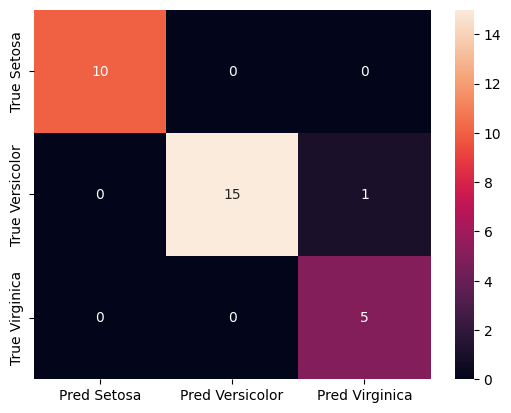

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [10]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="iris_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/iris_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="iris_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Iris Flower Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/196769/models/iris_model/1


Model(name: 'iris_model', version: 1)